<a href="https://colab.research.google.com/github/sungsushi/msci/blob/main/leaner_model/leaner_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Leaner model:
## No need for edge object creation, just make the paths from the array of points. 

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy 
import os
import time 
from google.colab import files
import copy 

def get_intercept(point): # generates 1e4 points and adj list in 3 sec
    return point[0] + point[1]

def gen_graph(N, seed=False): 
    # using box space condition
    if seed:
        np.random.seed(seed)
    #generate random coords in (0,1):
    x = np.random.random(N-2)
    y = np.random.random(N-2)

    
    
    unrotpoints = np.array([x,y])
    unrotpoints = unrotpoints[:,get_intercept(unrotpoints).argsort()].T # sort by ascending in causal order

    
    unrotpoints = np.insert(unrotpoints, [0], 0, axis=0) # add the (0,0) node to keep everything causal
    unrotpoints = np.insert(unrotpoints, [len(unrotpoints)], [1, 1], axis=0) # add the sink node
    
    points = np.array([unrotpoints[:,0]*np.cos(np.pi/4) - unrotpoints[:,1]*np.sin(np.pi/4), 
                     unrotpoints[:,1]*np.sin(np.pi/4) + unrotpoints[:,0]*np.cos(np.pi/4)]).T
    return points # only outputs coordinates sorted in time coordinate



In [2]:
def gen_graph_adj_2(N, seed=False): 
    # using box space condition
    if seed:
        np.random.seed(seed)
    #generate random coords in (0,1):
    x = np.random.random(N-2)
    y = np.random.random(N-2)

    
    
    unrotpoints = np.array([x,y])
    unrotpoints = unrotpoints[:,get_intercept(unrotpoints).argsort()].T # sort by ascending in causal order

    
    unrotpoints = np.insert(unrotpoints, [0], 0, axis=0) # add the (0,0) node to keep everything causal
    unrotpoints = np.insert(unrotpoints, [len(unrotpoints)], [1, 1], axis=0) # add the sink node
    
    adj = []
    for i in range(N): # need all adjacencies for algorithm but do we really?
        x_cond = (unrotpoints[i][0] - unrotpoints[i+1:][:,0]) < 0
        y_cond = (unrotpoints[i][1] - unrotpoints[i+1:][:,1]) < 0
        indices = np.where((x_cond * y_cond)==True)[0]
        adj.append(list(indices+i+1))

    points = np.array([unrotpoints[:,0]*np.cos(np.pi/4) - unrotpoints[:,1]*np.sin(np.pi/4), 
                     unrotpoints[:,1]*np.sin(np.pi/4) + unrotpoints[:,0]*np.cos(np.pi/4)]).T
    return points, adj

def edge_from_adj(adj):
    edges = []
    for i in range(len(adj)):
        for j in adj[i]:
            edges.append((i, j))
    return edges


In [3]:
# nb: no need for edge/adj list creation!

def ptgpath(points):
    # greedy in proper time. 
    # assume points are sorted by time coordinates
    current_node = 0
    path = [0]
    N = len(points)
    while current_node < N - 1:
        #print(current_node)
        c_node_coord = points[current_node]
        domain = points[current_node + 1:] # all nodes after current_node in time coordinate
        propertimes = (c_node_coord[0] - domain[:,0])**2 - (c_node_coord[1] - domain[:,1])**2
        invpt = 1/propertimes # inverse pt: numbers near 0 become large in magnitude
        index = np.argmin(invpt) # index of the smallest negative inverse pt (i.e. least negative pt)
        current_node += 1 + index # new current node index
        path.append(current_node) # add the new current node to the path
    return path # list of node labels 

def ptgpath_points(points):
    # greedy in proper time. 
    # assume points are sorted by its time coordinate
    current_node = 0
    path = [0]
    N = len(points)
    while current_node < N - 1:
        #print(current_node)
        c_node_coord = points[current_node]
        domain = points[current_node + 1:] # all nodes after current_node in time coordinate
        propertimes = (c_node_coord[0] - domain[:,0])**2 - (c_node_coord[1] - domain[:,1])**2
        invpt = 1/propertimes # inverse pt: numbers near 0 become large in magnitude
        index = np.argmin(invpt) # index of the smallest negative inverse pt (i.e. least negative pt)
        current_node += 1+ index # new current node
        path.append(current_node) # add the new current node to the path
    pathpoints = points[path]
    return pathpoints # array of coordinates in the path

def random_path_2Dpoints(points, seed=None):
    # returns the random path
    # points is the coordinates of nodes sorted in time coord
    if seed:
        np.random.seed(seed)
    N = len(points)
    current_node = 0
    path = [0]
    while current_node < N-1:
        c_node_coord = points[current_node]
        domain = points[current_node + 1:] # all nodes after current_node in time coordinate
        propertimes = (c_node_coord[0] - domain[:,0])**2 - (c_node_coord[1] - domain[:,1])**2
        causal = np.where(propertimes < 0)[0] # which indicies of propertimes are causal?
        index = np.random.choice(causal) # choose one of the indices at random
        current_node += 1+ index # new current node
        path.append(current_node) # add the new current node to the path
    
    pathpoints = points[path]
    return pathpoints


N = int(1e5) 
points = gen_graph(N, seed=1)

print(ptgpath(points))


[0, 775, 40955, 41767, 42091, 50551, 50686, 56997, 87200, 95647, 95849, 95901, 96359, 97326, 97626, 97714, 97790, 98172, 98307, 98343, 98612, 98893, 99640, 99655, 99685, 99720, 99830, 99868, 99925, 99932, 99946, 99950, 99973, 99975, 99984, 99991, 99994, 99999]


length of the longest path is: 14
length of the greedy path is: 13


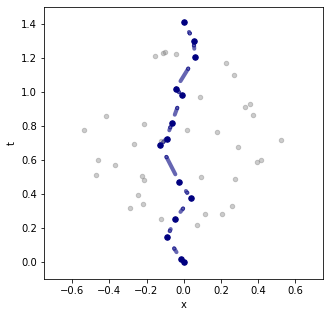

In [5]:
N = int(50) 
points, adj = gen_graph_adj_2(N, seed=1)
edgelist = edge_from_adj(adj)
pos = { i : points[i] for i in range(N) } #dictionary of node labels


G = nx.DiGraph()
G.add_edges_from(edgelist)

#G = nx.transitive_reduction(G) #### transitive reduction!!!

fig, ax = plt.subplots(figsize=(5,5))

# the longest path
path = nx.dag_longest_path(G)
# the longest path edge tuple list:
path_edges = set(zip(path,path[1:]))

#greedy path:
greedy_path = ptgpath(points)

#greedy path edge tuple list:
greedy_path_edges = set(zip(greedy_path,greedy_path[1:]))

#draw basic graph nodes (no edges):
nx.draw_networkx_nodes(G,pos,node_color='grey', node_size = 20, alpha=0.4)

#draw the nodes in the greedy path
nx.draw_networkx_nodes(G,pos,nodelist=greedy_path,node_color='navy', node_size = 30)

#draw the edges in the greedy path
nx.draw_networkx_edges(G,pos,edgelist=greedy_path_edges,edge_color='navy',width=4, arrowsize=1, alpha = 0.6)

limits=plt.axis('on') # turns on axis
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xlabel("x")
plt.ylabel("t")

plt.xlim(-0.75, 0.75)
plt.ylim(-0.1, 1.5)
#plt.savefig('dag_longestpath_5000.png')
#files.download('dag_longestpath_5000.png') 
print('length of the longest path is:', len(path)-1)
print('length of the greedy path is:', len(greedy_path)-1)
plt.show()

## Data taking:

In [ ]:
t_0 = time.time()

Ns = [int(1e1), int(5e1), int(1e2), int(5e2), int(1e3), int(5e3), 
      int(1e4), int(2e4), int(4e4), int(6e4), int(8e4), int(1e5)]

realisations = [int(1000), int(1000), int(1000), int(1000), int(1000), int(1000), 
                int(1000), int(1000), int(1000), int(1000), int(1000), int(1000)]


ptgreedy_path_points = []


for j in range(len(Ns)):
    N_ptg_coords = []

    for i in range(realisations[j]):
        points = gen_graph(Ns[j], seed= int(i + 1))
        ptgp = ptgpath_points(points)
        N_ptg_coords.append(ptgp)
    ptgreedy_path_points.append(N_ptg_coords)

many_paths = np.array([Ns, realisations,  ptgreedy_path_points], dtype=object)
#file_name = f"{realisations}_ptgreedypaths.npy"
#np.save(file_name, many_paths, allow_pickle=True)
#files.download(file_name) 

print('time taken = ', time.time() - t_0)



time taken =  95.89430570602417
